In [ ]:
# Load data from google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Import statements
import librosa
import numpy as np
import pandas as pd
import scipy
import csv
import sys
import glob
import pickle

In [ ]:
# Load data from pickle files
df_list = []
for filename in glob.glob("/content/drive/MyDrive/Colab Notebooks/ML Pickle Jar/*"):
  print("Processing " + filename)
  df = pd.read_pickle(filename)
  df_list.append(df)

sound_data = pd.concat(df_list, axis=0)
sound_data.count()

Processing /content/drive/MyDrive/Colab Notebooks/ML Pickle Jar/1000-2000_mfcc_EDA_data
Processing /content/drive/MyDrive/Colab Notebooks/ML Pickle Jar/2000-3000_mfcc_EDA_data
Processing /content/drive/MyDrive/Colab Notebooks/ML Pickle Jar/3000-4000_mfcc_EDA_data
Processing /content/drive/MyDrive/Colab Notebooks/ML Pickle Jar/4000-5000_mfcc_EDA_data
Processing /content/drive/MyDrive/Colab Notebooks/ML Pickle Jar/5000-6000_mfcc_EDA_data
Processing /content/drive/MyDrive/Colab Notebooks/ML Pickle Jar/6000-7000_mfcc_EDA_data
Processing /content/drive/MyDrive/Colab Notebooks/ML Pickle Jar/0001-1000_mfcc_EDA_data
Processing /content/drive/MyDrive/Colab Notebooks/ML Pickle Jar/7000-8000_mfcc_EDA_data
Processing /content/drive/MyDrive/Colab Notebooks/ML Pickle Jar/8000-9000_mfcc_EDA_data
Processing /content/drive/MyDrive/Colab Notebooks/ML Pickle Jar/9000-10000_mfcc_EDA_data
Processing /content/drive/MyDrive/Colab Notebooks/ML Pickle Jar/30000-35000_mfcc_EDA_data
Processing /content/drive/MyD

filename              73465
text                  73465
up_votes              73465
down_votes            73465
age                   73465
gender                73465
accent                63163
mean_RMSE             73465
mean_spec_centroid    73465
mfcc                  73465
meanff                72999
q1                    73465
iqr                   73465
chroma                73465
mel                   73465
dtype: int64

In [ ]:
sound_data = sound_data.sort_index(axis=0) 
sound_data

,filename,text,up_votes,down_votes,age,gender,accent,mean_RMSE,mean_spec_centroid,mfcc,meanff,q1,iqr,chroma,mel
0,cv-valid-train/sample-000005.mp3,a shepherd may like to travel but he should ne...,1,0,twenties,female,us,0.006932,1872.068718,"[[-752.60504, -730.3535, -712.5404, -711.55, -...",193.083434,0.211150,0.398957,"[0.50963885, 0.4695945, 0.4603954, 0.48003745,...","[0.00023007525, 0.00014125524, 0.00015047414, ..."
1,cv-valid-train/sample-000008.mp3,put jackie right on the staff,3,0,seventies,male,us,0.015068,2392.555799,"[[-682.6077, -657.9619, -592.8748, -546.271, -...",73.776776,0.350835,0.472287,"[0.55314964, 0.5806079, 0.69629747, 0.72144514...","[0.00015507598, 0.00031110694, 0.0020643708, 0..."
2,cv-valid-train/sample-000013.mp3,but he had found a guide and didn't want to mi...,1,0,thirties,female,us,0.038121,1863.409810,"[[-594.4625, -478.59122, -434.48297, -434.5027...",197.166506,0.477443,3.371958,"[0.57519054, 0.6260021, 0.56402045, 0.50898755...","[0.00035774417, 0.0002847947, 0.00039127853, 0..."
3,cv-valid-train/sample-000014.mp3,as they began to decorate the hallway a silhou...,1,0,sixties,male,england,0.032334,1836.372026,"[[-599.1911, -470.68686, -428.93854, -469.1475...",152.810185,0.791062,1.634413,"[0.5638525, 0.5700067, 0.6283644, 0.6683084, 0...","[0.0050621736, 0.00480701, 0.0048234495, 0.060..."
4,cv-valid-train/sample-000019.mp3,then they got ahold of some dough and went goofy,1,0,fifties,male,australia,0.045087,1870.815465,"[[-661.824, -661.824, -535.77356, -303.3603, -...",96.892631,1.543091,3.045843,"[0.6743262, 0.67634916, 0.71708095, 0.755776, ...","[1.1510695, 2.558978, 6.1211457, 9.659585, 7.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73461,cv-valid-train/sample-195766.mp3,but before i go i want to tell you a little story,1,0,fourties,male,england,0.112117,1874.815789,"[[-441.80307, -345.83603, -316.07602, -327.398...",114.783629,1.377083,2.650222,"[0.6611608, 0.5841805, 0.5251608, 0.4927581, 0...","[0.23971552, 0.34807414, 2.7860074, 27.334885,..."
73462,cv-valid-train/sample-195767.mp3,down below in the darkness were hundreds of pe...,3,0,thirties,female,us,0.007726,1956.440242,"[[-750.32196, -723.32166, -706.97534, -702.659...",175.643492,0.723267,1.596329,"[0.6474357, 0.6757682, 0.66542614, 0.65826356,...","[0.00011484503, 0.00019641899, 0.0004751418, 0..."
73463,cv-valid-train/sample-195770.mp3,he heard a muffled grating sound and saw the b...,4,0,twenties,male,england,0.042985,1575.157235,"[[-660.3753, -660.3753, -547.0556, -382.08624,...",85.790579,6.728792,4.414121,"[0.71263987, 0.72187686, 0.6750175, 0.6594301,...","[0.35012475, 0.91567373, 7.2036114, 8.911719, ..."
73464,cv-valid-train/sample-195771.mp3,the englishman said nothing,1,0,thirties,male,england,0.018556,2302.709109,"[[-700.3081, -700.3081, -700.3081, -698.8642, ...",121.380871,1.061520,2.111955,"[0.5877028, 0.5170463, 0.516343, 0.5301599, 0....","[0.0013285666, 0.0012072835, 0.003190259, 0.18..."


# **SVM**

In [ ]:
# Import statements
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Drop irrelevant columns
sound_data = sound_data.drop(columns=['up_votes','down_votes','text','accent'])
sound_data.head()


,filename,age,gender,mean_RMSE,mean_spec_centroid,mfcc,meanff,q1,iqr,chroma,mel
0,cv-valid-train/sample-000005.mp3,twenties,female,0.006932,1872.068718,"[[-752.60504, -730.3535, -712.5404, -711.55, -...",193.083434,0.211150,0.398957,"[0.50963885, 0.4695945, 0.4603954, 0.48003745,...","[0.00023007525, 0.00014125524, 0.00015047414, ..."
1,cv-valid-train/sample-000008.mp3,seventies,male,0.015068,2392.555799,"[[-682.6077, -657.9619, -592.8748, -546.271, -...",73.776776,0.350835,0.472287,"[0.55314964, 0.5806079, 0.69629747, 0.72144514...","[0.00015507598, 0.00031110694, 0.0020643708, 0..."
2,cv-valid-train/sample-000013.mp3,thirties,female,0.038121,1863.409810,"[[-594.4625, -478.59122, -434.48297, -434.5027...",197.166506,0.477443,3.371958,"[0.57519054, 0.6260021, 0.56402045, 0.50898755...","[0.00035774417, 0.0002847947, 0.00039127853, 0..."
3,cv-valid-train/sample-000014.mp3,sixties,male,0.032334,1836.372026,"[[-599.1911, -470.68686, -428.93854, -469.1475...",152.810185,0.791062,1.634413,"[0.5638525, 0.5700067, 0.6283644, 0.6683084, 0...","[0.0050621736, 0.00480701, 0.0048234495, 0.060..."
4,cv-valid-train/sample-000019.mp3,fifties,male,0.045087,1870.815465,"[[-661.824, -661.824, -535.77356, -303.3603, -...",96.892631,1.543091,3.045843,"[0.6743262, 0.67634916, 0.71708095, 0.755776, ...","[1.1510695, 2.558978, 6.1211457, 9.659585, 7.0..."


In [ ]:
# New dataframe
sound_data.reset_index(drop=True, inplace=True)
sound_data.tail()

,filename,age,gender,mean_RMSE,mean_spec_centroid,mfcc,meanff,q1,iqr,chroma,mel
73460,cv-valid-train/sample-195766.mp3,fourties,male,0.112117,1874.815789,"[[-441.80307, -345.83603, -316.07602, -327.398...",114.783629,1.377083,2.650222,"[0.6611608, 0.5841805, 0.5251608, 0.4927581, 0...","[0.23971552, 0.34807414, 2.7860074, 27.334885,..."
73461,cv-valid-train/sample-195767.mp3,thirties,female,0.007726,1956.440242,"[[-750.32196, -723.32166, -706.97534, -702.659...",175.643492,0.723267,1.596329,"[0.6474357, 0.6757682, 0.66542614, 0.65826356,...","[0.00011484503, 0.00019641899, 0.0004751418, 0..."
73462,cv-valid-train/sample-195770.mp3,twenties,male,0.042985,1575.157235,"[[-660.3753, -660.3753, -547.0556, -382.08624,...",85.790579,6.728792,4.414121,"[0.71263987, 0.72187686, 0.6750175, 0.6594301,...","[0.35012475, 0.91567373, 7.2036114, 8.911719, ..."
73463,cv-valid-train/sample-195771.mp3,thirties,male,0.018556,2302.709109,"[[-700.3081, -700.3081, -700.3081, -698.8642, ...",121.380871,1.061520,2.111955,"[0.5877028, 0.5170463, 0.516343, 0.5301599, 0....","[0.0013285666, 0.0012072835, 0.003190259, 0.18..."
73464,cv-valid-train/sample-195774.mp3,twenties,male,0.028044,1767.334739,"[[-665.49786, -665.49786, -541.8927, -373.8358...",90.920212,0.627414,0.642535,"[0.6673551, 0.6280248, 0.6160838, 0.65179384, ...","[1.2345352, 3.258969, 2.3398235, 12.511279, 3...."


In [ ]:
# Process features into a form usable for machine learning
# Features used : Spectral Centroid, Root Mean Squared Energy, Fundamental Frequency, Interquartile Range, Q1

# # Processing MFCC into MFCC mean
# sound_data.mfcc = sound_data.mfcc.apply(lambda x: [np.mean(m) for m in x])
# sound_data = pd.concat([sound_data,sound_data.mfcc.apply(pd.Series).add_prefix('mfcc_')], axis=1)
sound_data = sound_data.drop(columns=['mfcc'])

# # Processing chroma
# sound_data = pd.concat([sound_data,sound_data.chroma.apply(pd.Series).add_prefix('chroma_')], axis=1)
sound_data = sound_data.drop(columns=['chroma'])

# # Processing mel
# sound_data = pd.concat([sound_data,sound_data.mel.apply(pd.Series).add_prefix('mel_')], axis=1)
sound_data = sound_data.drop(columns=['mel'])

# Dropping NaN data
sound_data = sound_data.dropna(subset=['meanff'])

# Convert male to 0, female to 1
gen_dict = {"male": 0,"female": 1, "other": 2}

for x in range(len(sound_data['gender'])):
  sound_data['gender'].iloc[x] = gen_dict[sound_data['gender'].iloc[x]]

# Convert age to 0-6
age_dict = {"teens": 0,"twenties": 1, "thirties": 2, "fourties": 3, "fifties": 4, "sixties": 5, "seventies": 6, "eighties": 7}

for x in range(len(sound_data['age'])):
  sound_data['age'].iloc[x] = age_dict[sound_data['age'].iloc[x]]

sound_data.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,filename,age,gender,mean_RMSE,mean_spec_centroid,meanff,q1,iqr
0,cv-valid-train/sample-000005.mp3,1,1,0.006932,1872.068718,193.083434,0.211150,0.398957
1,cv-valid-train/sample-000008.mp3,6,0,0.015068,2392.555799,73.776776,0.350835,0.472287
2,cv-valid-train/sample-000013.mp3,2,1,0.038121,1863.409810,197.166506,0.477443,3.371958
3,cv-valid-train/sample-000014.mp3,5,0,0.032334,1836.372026,152.810185,0.791062,1.634413
4,cv-valid-train/sample-000019.mp3,4,0,0.045087,1870.815465,96.892631,1.543091,3.045843


# GENDER

In [ ]:
# Balancing dataset (remove others gender)
gender_data = sound_data.copy()
indexNames = gender_data[ (sound_data['gender'] == 2)].index
gender_data.drop(indexNames, inplace=True)
# indexNames = sound_data[ (sound_data['age'] == 6) | (sound_data['age'] == 7) ].index
# sound_data.drop(indexNames , inplace=True)
# indexNames = gender_data[ (gender_data['gender'] == 0) ].index
# gender_data.drop(indexNames[:36000] , inplace=True)
gender_data['gender'].value_counts()

0    54148
1    18080
Name: gender, dtype: int64

In [ ]:
# Construct features set
X = gender_data.drop(['filename', 'gender','age'], axis=1)
feature_names = list(X.columns)
X = X.values
labels = np.sort(np.unique(gender_data.gender.values))
num_class = len(labels)
c2i = {}
i2c = {}
for i, c in enumerate(labels):
    c2i[c] = i
    i2c[i] = c
y = np.array([c2i[x] for x in gender_data.gender.values])

#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = True)

In [ ]:
# Use oversampling to balance dataset
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(random_state = 0)
os_x, os_y = oversampler.fit_sample(X, y)
X_train, x_test, y_train, y_test = train_test_split(os_x, os_y, test_size = 0.2, random_state = 42, shuffle = True)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# Fit an SVM model

clf = SVC(kernel = 'rbf', probability=True)

clf.fit(X_train, y_train)


In [ ]:
import sklearn

print(accuracy_score(clf.predict(x_test), y_test))
y_test_pred = clf.predict(x_test)

0.8827793167128347


In [ ]:
print(sklearn.metrics.f1_score(y_test,y_test_pred))
print(sklearn.metrics.recall_score(y_test,y_test_pred))
print(sklearn.metrics.precision_score(y_test,y_test_pred))

0.8819673655339129
0.8826649297478366
0.8812709030100334


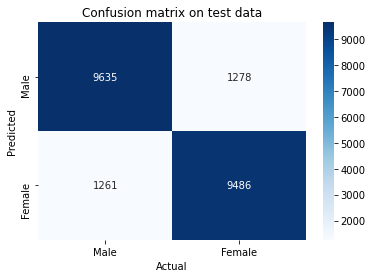

In [ ]:
#plot confusion matrix

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm, datasets
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(confusion_matrix(y_test,y_test_pred) , index = ['Male', 'Female'] , columns = ['Male', 'Female'])
sns.heatmap(cm,cmap= 'Blues', annot = True, fmt='', xticklabels = ['Male', 'Female'], yticklabels = ['Male', 'Female'])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('Confusion matrix on test data')
plt.show()

In [ ]:
filename = 'svm_gender_model_base.sav'
pickle.dump(clf, open(filename, 'wb'))

In [ ]:
file = open(filename,"rb")
gender_model_load = pickle.load(file)

print(accuracy_score(gender_model_load.predict(X_val), y_val))

0.8975986751311068


# AGE



In [ ]:
# Balancing dataset (remove others gender)
age_data = sound_data.copy()
indexNames = age_data[ (age_data['age'] == 6) | (age_data['age'] == 7) ].index
age_data.drop(indexNames , inplace=True)

# for i in range(6):
#   current = len(age_data[age_data.age == i])
#   desired = 2500
#   cut = current - desired
#   if cut > 0:
#     indexNames = age_data[ (age_data['age'] == i)].index
#     age_data.drop(indexNames[:cut] , inplace=True)
age_data['age'].value_counts()

1    22806
2    18147
3    10830
4     9417
0     5389
5     4570
Name: age, dtype: int64

In [ ]:
# Construct features set
X = age_data.drop(['filename', 'age', 'gender'], axis=1)
feature_names = list(X.columns)
X = X.values
labels = np.sort(np.unique(age_data.age.values))
num_class = len(labels)
c2i = {}
i2c = {}
for i, c in enumerate(labels):
    c2i[c] = i
    i2c[i] = c
y = np.array([c2i[x] for x in age_data.age.values])

#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = True)

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(random_state = 0)
os_x, os_y = oversampler.fit_sample(X, y)
X_train, X_val, y_train, y_val = train_test_split(os_x, os_y, test_size = 0.2, random_state = 42, shuffle = True)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# Fit an SVM model

clf_age = SVC(kernel = 'rbf', probability=True)

clf_age.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
y_test_pred = clf_age.predict(X_val)
print(accuracy_score(y_val,y_test_pred))
print(sklearn.metrics.f1_score(y_val, y_test_pred, average='weighted'))
print(sklearn.metrics.recall_score(y_val,y_test_pred, average='weighted'))
print(sklearn.metrics.precision_score(y_val,y_test_pred, average='weighted'))


0.20721280327389652
0.17425776372601656
0.20721280327389652
0.21923495553774994


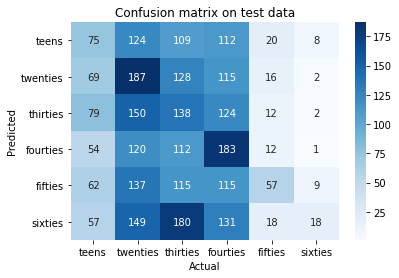

In [ ]:
#plot confusion matrix for age
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm, datasets
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(confusion_matrix(y_val,y_test_pred) , index = ['teens','twenties','thirties','fourties','fifties','sixties'] , columns = ['teens','twenties','thirties','fourties','fifties','sixties'])
sns.heatmap(cm,cmap= 'Blues', annot = True, fmt='', xticklabels = ['teens','twenties','thirties','fourties','fifties','sixties'], yticklabels = ['teens','twenties','thirties','fourties','fifties','sixties'])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('Confusion matrix on test data')
plt.show()

In [ ]:
predicted = clf_age.predict(X)

sound_data_copy = sound_data
sound_data_copy["predicted"] = predicted
sound_data_copy.head(100)

,filename,age,gender,mean_RMSE,mean_spec_centroid,meanff,q1,iqr,chroma,mel,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,predicted
3,cv-valid-train/sample-000014.mp3,5,0,0.032334,1836.372026,152.810185,0.791062,1.634413,0.572061,0.455532,-419.375793,103.713593,15.190497,36.283360,1.738739,-13.215077,-13.929633,-7.724552,-10.377790,-6.689550,-4.351950,-5.704678,-0.586958,-6.024174,-6.212928,1.110269,-10.488708,-3.868648,2.190315,-8.519909,1
15,cv-valid-train/sample-000047.mp3,5,0,0.067068,1475.096680,94.093279,2.235830,4.482680,0.479016,2.681611,-379.507294,77.769272,-16.508028,23.562738,0.359637,3.708098,-13.866529,-0.771588,-14.677774,-10.091537,-4.274249,-13.142458,-1.590355,-2.955199,2.793320,-1.338633,-4.119541,-7.107502,-5.539372,-4.732266,1
46,cv-valid-train/sample-000132.mp3,5,0,0.068894,2041.411610,105.541198,1.659976,3.427150,0.626419,2.058398,-323.951599,115.146973,18.029148,21.916729,24.264469,-14.617676,-1.536109,7.865913,-8.715315,-9.891705,-2.097215,-15.726994,-11.633720,6.725719,-2.102260,-1.093686,-8.093146,1.435906,-2.687398,-5.196330,1
71,cv-valid-train/sample-000201.mp3,5,0,0.108590,1363.307297,111.394008,0.968841,2.648198,0.527694,5.727751,-320.280670,121.279274,-2.412653,27.326727,-5.547801,-4.193234,-0.457921,-14.063418,-17.613281,-2.162922,0.012095,-8.414882,-3.618963,-6.360165,-5.034638,-9.086490,-5.377142,0.398590,1.492073,1.471020,1
94,cv-valid-train/sample-000254.mp3,5,0,0.040129,1678.627441,100.087788,4.864932,3.863946,0.731132,0.733549,-272.884857,138.227768,-9.347962,5.517119,0.076048,13.804235,-3.206502,18.313471,-14.578416,5.525807,8.734128,5.137185,-7.708284,2.420851,6.918280,4.871679,-7.473747,5.586852,-4.281948,2.507699,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1567,cv-valid-train/sample-004211.mp3,5,1,0.019846,2767.078843,201.090183,1.203807,1.990147,0.516507,0.161959,-452.386261,57.237091,-24.869312,48.791271,-16.299078,1.943727,-8.112625,-4.743412,-0.817608,-5.038141,-6.047719,-5.761878,-9.474676,-10.804551,-0.215464,-12.130686,-6.942430,-3.617003,-3.556221,-10.376414,2
1588,cv-valid-train/sample-004275.mp3,5,1,0.083435,3103.529145,254.424702,4.373949,8.872476,0.618894,3.586338,-258.412872,63.339504,-15.444813,5.856495,-5.719127,-9.708732,-6.421681,-8.322394,-8.397270,3.983163,-13.237484,-1.004280,-7.666359,-5.386288,-4.463066,-5.904234,-11.555969,-4.473116,-9.573938,-3.629288,3
1597,cv-valid-train/sample-004299.mp3,5,0,0.007778,3023.398151,222.152749,0.160766,0.220641,0.735596,0.055825,-595.942139,56.345501,-0.044505,14.246099,-3.749856,-2.973634,-11.399929,0.205588,-15.347019,-5.510203,0.179481,-8.925974,-3.020930,-7.178001,-0.965600,-2.880386,-5.841918,-4.869396,0.317864,-3.603639,3
1640,cv-valid-train/sample-004394.mp3,5,0,0.056903,2257.301576,91.353401,2.893498,5.041519,0.660477,1.563220,-345.817200,98.081169,-9.709068,20.632990,5.718905,3.557922,-4.839841,-2.312765,-8.446874,5.473046,0.605506,-0.702945,2.124959,-6.309040,-3.999285,5.592984,-5.077385,-3.643554,-3.194158,-0.888088,2


In [ ]:
sound_data_copy['predicted'].value_counts()

2    8254
1    8213
3    6349
5    2071
4    1475
0     897
Name: predicted, dtype: int64

In [ ]:
filename = 'svm_age_model_base.sav'
pickle.dump(clf_age, open(filename, 'wb'))

In [ ]:
model = pickle.load('/content/drive/MyDrive/Colab Notebooks/ML Pickle Jar/svm_age_model.sav')
